In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Project 1: A gratuitously complex adding machine

## Create the training data

In [ ]:
# create data

N = 2000

# generate data
data = torch.randint(low=-10, high=11, size=(N,2)).float()

# labels
labels = torch.sum(data, axis=1, keepdim=True)

# print the data
for i in range(N):
    print(data[i], labels[i])

In [6]:
labels.shape

torch.Size([2000, 1])

## Design the model

In [7]:
# a function that builds the model
def createADDmodel():

    # model architecture
    ANNclassify = nn.Sequential(
        nn.Linear(2,30),
        nn.ReLU(),
        nn.Linear(30,1),
        nn.ReLU(),
        nn.Linear(1,1),
    )

    lossfunc = nn.MSELoss()
    optimizer = torch.optim.Adam(ANNclassify.parameters(), lr=.01)

    return ANNclassify, lossfunc, optimizer

## Train the model

In [10]:
# a function that trains the model

# a fixed paramter
numepochs = 10

def trainTheModel():

    ADDmodel, lossfunc, optimizer = createADDmodel()

    losses = torch.zeros(numepochs)

    for epochi in range(numepochs):

        numloss = []
        # loop through "minibatches" of N=1
        for num, ans in zip(data, labels):

            # forward pass
            yHat = ADDmodel(num)

            # compute loss
            loss = lossfunc(yHat, ans)
            numloss.append(loss.item())

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses[epochi] = np.mean(numloss)

        # final forward pass
        with torch.no_grad():
            predictions = ADDmodel(data)

        # compute the predictions and report accuracy (is this really different from loss?)
        train_acc = 100 * torch.mean( (np.abs(predictions-labels)<1).float() ).item() # <1 for rounding

        # now test with new data!
        # create brand new test data
        TESTdata = torch.randint(low=-10, high=11, size=(N,2)).float()
        TESTlabels = torch.sum(TESTdata, axis=1, keepdim=True)

        # evaluate the model and compute accuracy
        with torch.no_grad():
            predictions = ADDmodel(TESTdata)
        test_acc = 100 * torch.mean( (np.abs(predictions-TESTlabels)<1).float() ).item()

    return losses, train_acc, test_acc, ADDmodel

In [11]:
# test the model once to make sure it runs
losses, train_acc, test_acc, ADDmodel = trainTheModel()

In [12]:
# print the results
train_acc, test_acc

(96.29999995231628, 95.74999809265137)

## Run the experiment!

In [14]:
# run the model 10 times to check reproducibility
for i in range(10):

    # create a new 'machine' and train it
    _, trainacc, testacc, ADDmodel = trainTheModel()

    # report accuracy
    print('Model instance %s, final TRAIN/TEST accuracies: %g%%, %g%%' %(i+1, trainacc, testacc))

Model instance 1, final TRAIN/TEST accuracies: 9.4%, 9.55%
Model instance 2, final TRAIN/TEST accuracies: 9.4%, 9.3%
Model instance 3, final TRAIN/TEST accuracies: 9.4%, 9.5%
Model instance 4, final TRAIN/TEST accuracies: 9.4%, 9.05%
Model instance 5, final TRAIN/TEST accuracies: 9.4%, 8.6%
Model instance 6, final TRAIN/TEST accuracies: 99.85%, 99.55%
Model instance 7, final TRAIN/TEST accuracies: 99.75%, 99.8%
Model instance 8, final TRAIN/TEST accuracies: 75.25%, 73.85%
Model instance 9, final TRAIN/TEST accuracies: 9.4%, 10.2%
Model instance 10, final TRAIN/TEST accuracies: 99.75%, 99.8%


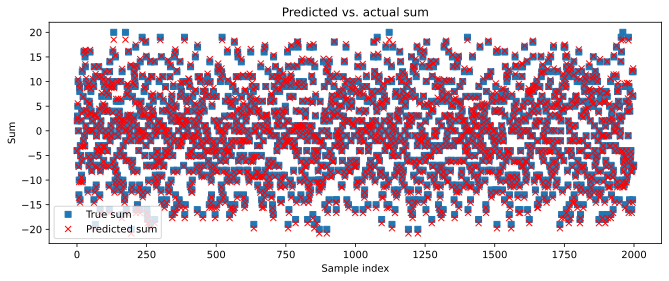

In [15]:
# some plots from the final model

data = torch.randint(low=-10, high=11, size=(N,2)).float()
labels = torch.sum(data, axis=1, keepdim=True)

# evaluate the model and compute accuracy
with torch.no_grad():
    predictions = ADDmodel(data)

# true and predicted values
fig = plt.figure(figsize=(11,4))
plt.plot(labels, 's')
plt.plot(predictions, 'rx')
plt.legend(['True sum', 'Predicted sum'])
plt.xlabel('Sample index')
plt.ylabel('Sum')
plt.title('Predicted vs. actual sum')

plt.show()

# Project 2: Predicting heart disease

In [ ]:
# https://towardsdatascience.com/heart-disease-prediction-73468d630cfc
# Classification models for heart disease prediction using feature selection and PCA

# Data information:
# https://archive.ics.uci.edu/ml/datasets/Heart+Disease

# Data source
# https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

## Import & Clean/preprocess the data

In [16]:
# import the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url, sep=',', header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']

# data contain some ?'s; replace with NaN and drop those rows
data = data.replace('?', np.nan).dropna()

data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3


In [17]:
# describe the data
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,DISEASE
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


<ipython-input-21-73d67e6402e9>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


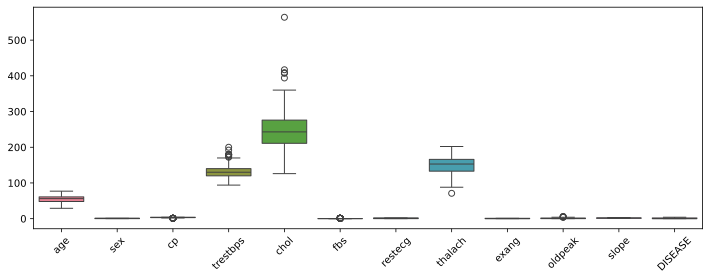

In [21]:
# check the distributions
fig, ax = plt.subplots(1,figsize=(12,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [22]:
# z-score the non-categorical columns
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(['sex', 'exang', 'DISEASE'])
cols2zscore

Index(['age', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'oldpeak',
       'slope', 'ca', 'thal'],
      dtype='object')

In [23]:
for c in cols2zscore:
    d = pd.to_numeric(data[c]) # force to numeric (addresses some data-format issues)
    data[c] = (d - d.mean()) / d.std(ddof=1)

<ipython-input-24-951ef38bc046>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


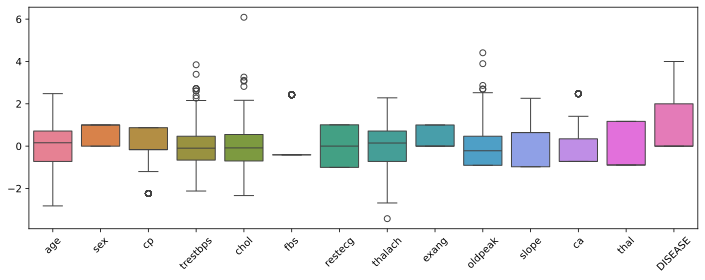

In [24]:
# check the distributions again
fig, ax = plt.subplots(1,figsize=(12,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [25]:
# count of all unique types of 'DISEASE'
data['DISEASE'].value_counts()

0    160
1     54
2     35
3     35
4     13
Name: DISEASE, dtype: int64

In [26]:
# re-code events to 0 (absent) and 1 (present)
data['DISEASE'] [data['DISEASE']>0] = 1

<ipython-input-26-5ff47293bc2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DISEASE'] [data['DISEASE']>0] = 1


In [27]:
data['DISEASE'].value_counts()

0    160
1    137
Name: DISEASE, dtype: int64

## Re-organize the data: train/test in DataLoaders

In [29]:
data_tensor = torch.tensor(data[data.keys().drop('DISEASE')].values).float()
labels = torch.tensor(data['DISEASE'].values).float()

print(data_tensor.shape)
print(labels.shape)

labels = labels[:,None]
print(labels.shape)

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels, test_size=50)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=20
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

torch.Size([297, 13])
torch.Size([297])
torch.Size([297, 1])


In [30]:
# check sizes of data loaders
for X, y in train_loader:
    print(X.shape, y.shape)

torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])


## Create a class for the DL model

In [31]:
# the class
class theNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(13,32)
        self.fc1 = nn.Linear(32,64)
        self.fc2 = nn.Linear(64,10)
        self.output = nn.Linear(10,1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

## Test the model on a bit of data

In [32]:
net = theNet()

X, y = next(iter(train_loader))
yHat = net(X)
print(yHat)

# test the loss function
lossfunc = nn.BCEWithLogitsLoss()
lossfunc(yHat, y)

tensor([[-0.1356],
        [-0.1631],
        [-0.1678],
        [-0.1509],
        [-0.1508],
        [-0.1386],
        [-0.1225],
        [-0.1389],
        [-0.1764],
        [-0.1544],
        [-0.1023],
        [-0.1300],
        [-0.1838],
        [-0.1225],
        [-0.1231],
        [-0.1418],
        [-0.1446],
        [-0.1178],
        [-0.1343],
        [-0.1394]], grad_fn=<AddmmBackward0>)


tensor(0.6688, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Train the model and show performance

In [37]:
# start with a fresh network
net = theNet()
optimizer = torch.optim.Adam(net.parameters(), lr=.0001)
lossfunc = nn.BCEWithLogitsLoss() # try with different loss function

numepochs = 100

trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)

for epochi in range(numepochs):

    batchLoss = []
    batchAcc = []
    for X, y in train_loader:
        yHat = net(X)
        loss = lossfunc(yHat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())

        predictions = (torch.sigmoid(yHat)>.5).float()
        batchAcc.append( 100 * torch.mean((predictions==y).float()).item() )
    # end of batch loop...

    # get average losses & acc across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = np.mean(batchAcc)

    # now for the test
    X, y = next(iter(test_loader))
    yHat = net(X)

    loss = lossfunc(yHat, y)
    testLoss[epochi] = loss.item()

    predictions = (torch.sigmoid(yHat)>.5).float()
    testAcc[epochi] = 100 * torch.mean((predictions==y).float()).item()

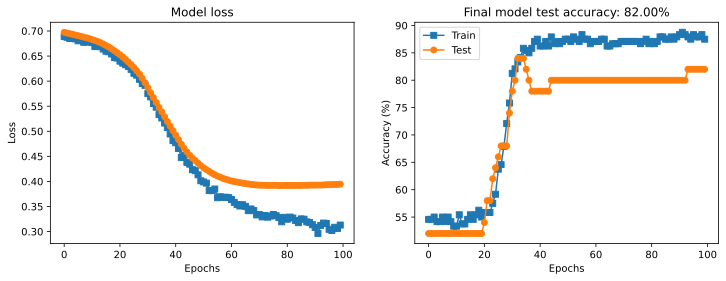

In [38]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(testLoss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-', label='Train')
ax[1].plot(testAcc, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Project 3: FFN for missing data interpolation

In [ ]:
''' Missing data
- option 1: Complete removal
- option 2: Selective removal
- option 3: Replacement
- option 4: Prediction - Used for: Enough data and other columns (features) to generate a useful predictive model.
'''

In [ ]:
'''
- Import the 'wine' dataset.
- Choose 10 random data values in the 'residual sugar' column to replace with NaN.
- Split the data into TRAIN (has 'residual supar' value) and TEST (missing values).
- Train the model. Predict the missing values.
'''

## Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# z-score all columns
data = (data - data.mean()) / data.std(ddof=1)

# save a copy of the data (because we'll replace some values with nan's below)
dataOrig = copy.deepcopy(data)

## Replace some elements with NaN

In [3]:
# number of data points to set missing
n2nan = 10

# pick n random rows to set to nan
vals2nan = np.random.choice(range(len(data)), size=n2nan, replace=False)

# set those values to be nan
data['residual sugar'][vals2nan] = np.nan

# for splitting the data, it will be helpful to have a vector of all real-valued rows
vals2NotNan = np.where(~data['residual sugar'].isna())[0]

# confirm
print(np.sort(vals2nan))
print(np.where(data['residual sugar'].isna())[0])

[ 174  470  549  589  617  710 1130 1295 1400 1467]
[ 174  470  549  589  617  710 1130 1295 1400 1467]


## Re-organize the data: train/test in DataLoaders

In [4]:
# convert from pandas dataframe to tensor

# vector with residual sugar dropped, for training data
cols2keep = data.keys()
cols2keep = cols2keep.drop('residual sugar')

# extract dataframe to TRAIN tensors
train_data_tensor = torch.tensor(data[cols2keep].values).float()
train_data_tensor = train_data_tensor[vals2NotNan, :]
train_label_tensor = torch.tensor(data['residual sugar'].values).float()
train_label_tensor = train_label_tensor[vals2NotNan, None] # 'None' is transform to matrix

# same for TEST tensors
test_data_tensor = torch.tensor(data[cols2keep].values).float()
test_data_tensor = test_data_tensor[vals2nan, :]
test_label_tensor = torch.tensor(dataOrig['residual sugar'].values).float()
test_label_tensor = test_label_tensor[vals2nan, None]

# confirm sizes
print(f'Original data: {data.shape}\n')
print(f'Train data: {train_data_tensor.shape}\n')
print(f'Train labels: {train_label_tensor.shape}\n')
print(f'Test data: {test_data_tensor.shape}\n')
print(f'Test labels: {test_label_tensor.shape}')

Original data: (1599, 12)

Train data: torch.Size([1589, 11])

Train labels: torch.Size([1589, 1])

Test data: torch.Size([10, 11])

Test labels: torch.Size([10, 1])


In [5]:
# convert into PyTorch Datasets
trainset = TensorDataset(train_data_tensor, train_label_tensor)
testset = TensorDataset(test_data_tensor, test_label_tensor)

# translate into dataloader objects
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)

## Now for the DL part

In [6]:
# create a class for the model
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11,16)
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)
        self.output = nn.Linear(32,1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

## Train the model

In [9]:
# a function that trains the model

numepochs = 400

def trainTheModel(winenet):

    lossfunc = nn.MSELoss()
    optimizer = torch.optim.Adam(winenet.parameters(), lr=.01)

    trainLoss = torch.zeros(numepochs)

    for epochi in range(numepochs):

        batchLoss = []
        for X, y in train_loader:
            yHat = winenet(X)
            loss = lossfunc(yHat,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        trainLoss[epochi] = np.mean(batchLoss)

    return trainLoss

In [10]:
# create a model and train it
winenet = ANNwine()
trainLoss = trainTheModel(winenet)

In [11]:
# get the predictions for the missing data
yHatTrain = winenet(train_data_tensor)
yHatTest = winenet(test_data_tensor)

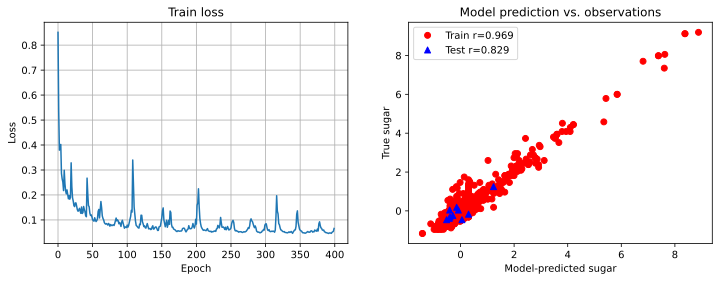

In [13]:
# plot results
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(trainLoss, label='Train loss')
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid()

ax[1].plot(yHatTrain.detach(), train_label_tensor, 'ro')
ax[1].plot(yHatTest.detach(), test_label_tensor, 'b^')
ax[1].set_ylabel('True sugar')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_title('Model prediction vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T, train_label_tensor.T)[1,0]
corrTest = np.corrcoef(yHatTest.detach().T, test_label_tensor.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}', f'Test r={corrTest:.3f}' ])

plt.show()